iter 0, residual 3.409e+02
iter 100, residual 2.096e+00
iter 200, residual 4.007e-01
iter 300, residual 8.543e-02
iter 400, residual 1.916e-02
iter 500, residual 4.417e-03
iter 600, residual 1.035e-03
iter 700, residual 2.445e-04
iter 800, residual 5.812e-05
converged 800 5.811907241159986e-05
Solver time: 0.251 s


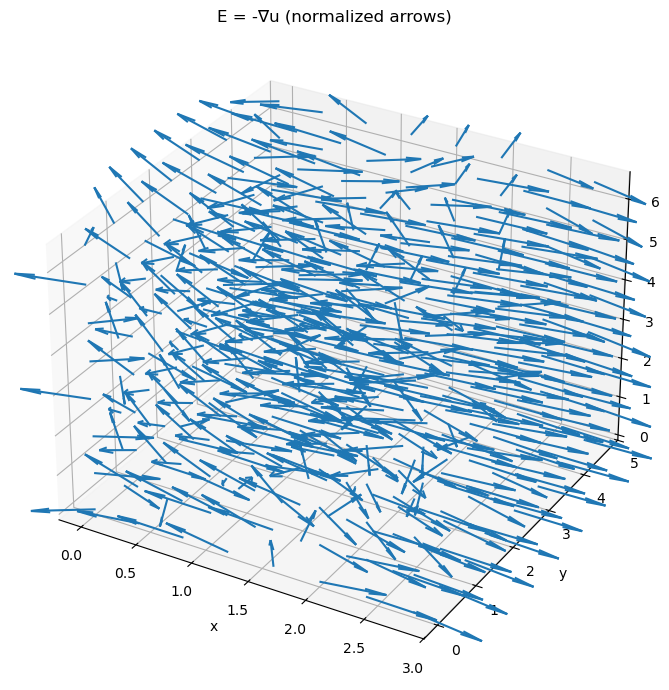

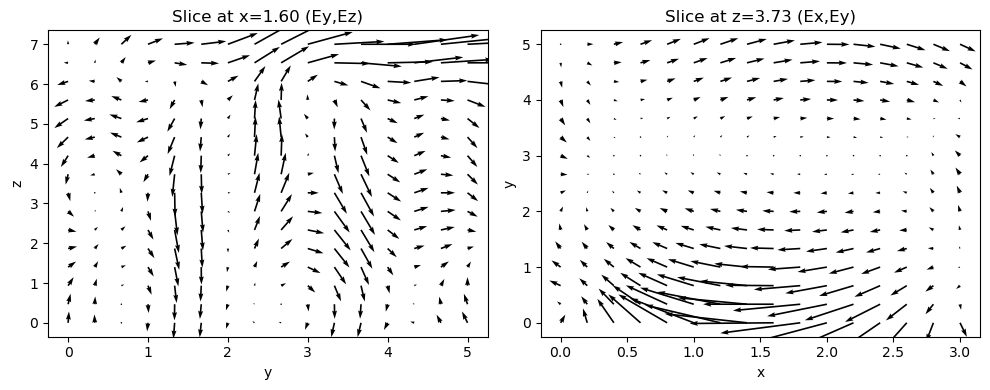

Done. Files saved: E_field_3d.png, E_slices.png


In [6]:
"""
solve_and_plot_poisson.py

Решение Δu = -rho в прямоугольнике [0,a]x[0,b]x[0,c] с:
 - Дирихле на x=0 и x=a (u задан)
 - Нейман на y=0,y=b и z=0,z=c (заданы производные)
Вычисляет u численно (конечно-разностная схема, итерационный Jacobi по срезам),
затем E = -∇u и строит векторное поле (3D quiver + 2 среза).
"""
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

eps = 1.0
a, b, c = 3.0, 5.0, 7.0

def rho_fun(x, y, z):
    return x**2 + y

def uy_y0(x, z):  
    return -z * np.sin(2*x)

def uy_yb(x, z):   
    return -z * np.sin(2*x + 5)

def uz_z0_zc(x, y): 
    return np.cos(2*x + y)

def u_x0(x, y, z):
    return z * np.cos(y) + y**2 * (y - 5)**2 * np.cos(5*np.pi*z/7)

def u_xa(x, y, z):  # u at x=a
    return z * np.cos(y + 6) + np.cos(np.pi*y/5) * np.cos(6*np.pi*z/7)

Nx, Ny, Nz = 16, 16, 16  
x = np.linspace(0, a, Nx)
y = np.linspace(0, b, Ny)
z = np.linspace(0, c, Nz)
dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

u = np.zeros_like(X)
u[0,:,:] = u_x0(x[0], y[:, None], z[None, :])
u[-1,:,:] = u_xa(x[-1], y[:, None], z[None, :])
rho = rho_fun(X, Y, Z)

max_iter = 3000
tol = 2e-4
omega = 1.0 

coef_x = 1.0/dx**2
coef_y = 1.0/dy**2
coef_z = 1.0/dz**2
denom = 2*(coef_x + coef_y + coef_z)

start = time.time()
for it in range(max_iter):
    u_new = u.copy()
    numerator = (u[2:,1:-1,1:-1] + u[:-2,1:-1,1:-1]) * coef_x + \
                (u[1:-1,2:,1:-1] + u[1:-1,:-2,1:-1]) * coef_y + \
                (u[1:-1,1:-1,2:] + u[1:-1,1:-1,:-2]) * coef_z + \
                rho[1:-1,1:-1,1:-1]
    u_new[1:-1,1:-1,1:-1] = numerator / denom

    u_new[0,:,:] = u_x0(x[0], y[:, None], z[None, :])
    u_new[-1,:,:] = u_xa(x[-1], y[:, None], z[None, :])

    u = u + omega*(u_new - u)

    gx_y0 = uy_y0(X[:,0,:], Z[:,0,:])
    u[:,0,:] = u[:,1,:] - dy * gx_y0

    gx_yb = uy_yb(X[:,-1,:], Z[:,-1,:])
    u[:,-1,:] = u[:,-2,:] + dy * gx_yb

    gz_z0 = uz_z0_zc(X[:,:,0], Y[:,:,0])
    u[:,:,0] = u[:,:,1] - dz * gz_z0

    gz_zc = uz_z0_zc(X[:,:,-1], Y[:,:,-1])
    u[:,:,-1] = u[:,:,-2] + dz * gz_zc

    u[0,:,:] = u_x0(x[0], y[:, None], z[None, :])
    u[-1,:,:] = u_xa(x[-1], y[:, None], z[None, :])

    if it % 100 == 0:
        lap = np.zeros_like(u)
        lap[1:-1,1:-1,1:-1] = (u[2:,1:-1,1:-1] -2*u[1:-1,1:-1,1:-1] + u[:-2,1:-1,1:-1])*coef_x + \
                              (u[1:-1,2:,1:-1] -2*u[1:-1,1:-1,1:-1] + u[1:-1,:-2,1:-1])*coef_y + \
                              (u[1:-1,1:-1,2:] -2*u[1:-1,1:-1,1:-1] + u[1:-1,1:-1,:-2])*coef_z
        res = np.max(np.abs(lap[1:-1,1:-1,1:-1] + rho[1:-1,1:-1,1:-1]))  # lap + rho ≈ 0
        print(f"iter {it}, residual {res:.3e}")
        if res < tol:
            print("converged", it, res)
            break
else:
    print("no convergence, last residual maybe > tol")

print("Solver time: {:.3f} s".format(time.time() - start))

Ex = np.zeros_like(u); Ey = np.zeros_like(u); Ez = np.zeros_like(u)
Ex[1:-1,:,:] = -(u[2:,:,:] - u[:-2,:,:])/(2*dx)
Ey[:,1:-1,:] = -(u[:,2:,:] - u[:,:-2,:])/(2*dy)
Ez[:,:,1:-1] = -(u[:,:,2:] - u[:,:,:-2])/(2*dz)

Ex[0,:,:]  = -(u[1,:,:] - u[0,:,:])/dx
Ex[-1,:,:] = -(u[-1,:,:] - u[-2,:,:])/dx
Ey[:,0,:]  = -(u[:,1,:] - u[:,0,:])/dy
Ey[:,-1,:] = -(u[:,-1,:] - u[:,-2,:])/dy
Ez[:,:,0]  = -(u[:,:,1] - u[:,:,0])/dz
Ez[:,:,-1] = -(u[:,:,-1] - u[:,:,-2])/dz

skip = max(1, Nx//7)
xs = X[::skip, ::skip, ::skip]
ys = Y[::skip, ::skip, ::skip]
zs = Z[::skip, ::skip, ::skip]
Exs = Ex[::skip, ::skip, ::skip]
Eys = Ey[::skip, ::skip, ::skip]
Ezs = Ez[::skip, ::skip, ::skip]

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

mag = np.sqrt(Exs**2 + Eys**2 + Ezs**2)
nonzero = mag > 0
Exs_n = np.copy(Exs); Eys_n = np.copy(Eys); Ezs_n = np.copy(Ezs)
Exs_n[nonzero] /= mag[nonzero]; Eys_n[nonzero] /= mag[nonzero]; Ezs_n[nonzero] /= mag[nonzero]

ax.quiver(xs.flatten(), ys.flatten(), zs.flatten(),
          Exs_n.flatten(), Eys_n.flatten(), Ezs_n.flatten(),
          length=0.6, normalize=False)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.set_title('E = -∇u (normalized arrows)')
plt.tight_layout()
plt.savefig('E_field_3d.png', dpi=200)
plt.show()

mid_i = Nx//2
mid_k = Nz//2

fig2 = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
Ygrid = Y[mid_i,:,:]
Zgrid = Z[mid_i,:,:]
plt.quiver(Ygrid, Zgrid, Ey[mid_i,:,:].T, Ez[mid_i,:,:].T)
plt.xlabel('y'); plt.ylabel('z'); plt.title(f'Slice at x={x[mid_i]:.2f} (Ey,Ez)')

plt.subplot(1,2,2)
Xgrid = X[:,:,mid_k]
Ygrid2 = Y[:,:,mid_k]
plt.quiver(Xgrid, Ygrid2, Ex[:,:,mid_k].T, Ey[:,:,mid_k].T)
plt.xlabel('x'); plt.ylabel('y'); plt.title(f'Slice at z={z[mid_k]:.2f} (Ex,Ey)')

plt.tight_layout()
plt.savefig('E_slices.png', dpi=200)
plt.show()

print("Done. Files saved: E_field_3d.png, E_slices.png")

iter 0, residual 3.200e+01
iter 100, residual 7.534e-01
iter 200, residual 3.526e-01
iter 300, residual 2.204e-01
iter 400, residual 1.569e-01
iter 500, residual 1.202e-01
iter 600, residual 9.646e-02
iter 700, residual 7.930e-02
iter 800, residual 6.614e-02
iter 900, residual 5.548e-02
iter 1000, residual 4.674e-02
iter 1100, residual 3.948e-02
iter 1200, residual 3.341e-02
iter 1300, residual 2.832e-02
iter 1400, residual 2.402e-02
iter 1500, residual 2.039e-02
iter 1600, residual 1.732e-02
iter 1700, residual 1.471e-02
iter 1800, residual 1.250e-02
iter 1900, residual 1.062e-02
iter 2000, residual 9.028e-03
iter 2100, residual 7.673e-03
iter 2200, residual 6.522e-03
iter 2300, residual 5.544e-03
iter 2400, residual 4.713e-03
iter 2500, residual 4.006e-03
iter 2600, residual 3.405e-03
iter 2700, residual 2.895e-03
iter 2800, residual 2.461e-03
iter 2900, residual 2.092e-03
iter 3000, residual 1.778e-03
iter 3100, residual 1.512e-03
iter 3200, residual 1.285e-03
iter 3300, residual 1.

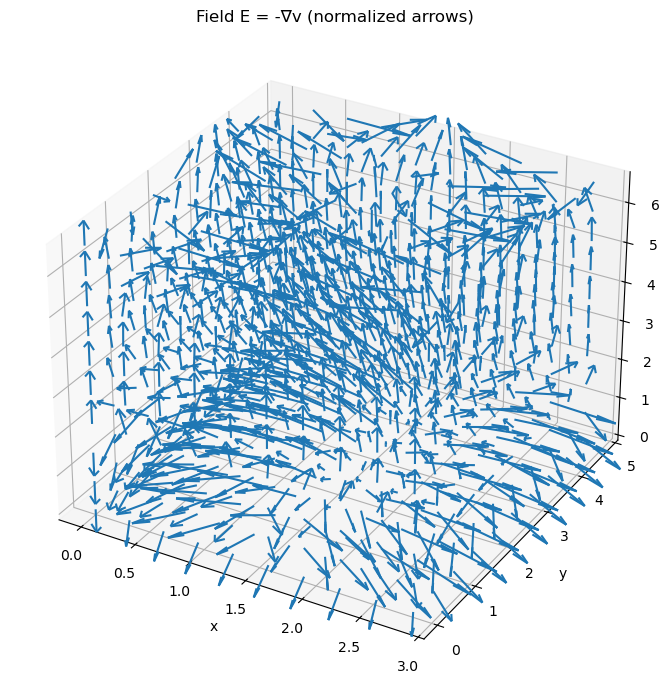

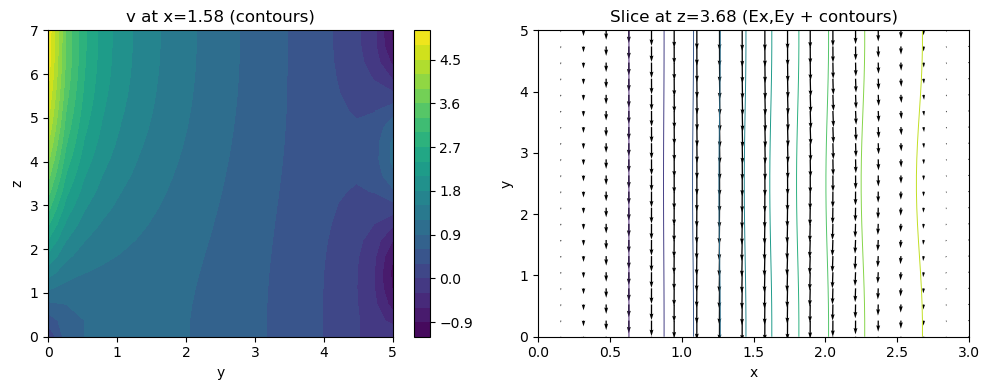

Saved: v_field_3d_quiver.png, v_slices.png


In [8]:
"""
plot_v_field.py

Решение Δv = 0 в прямоугольном параллелепипеде [0,a]x[0,b]x[0,c] с граничными условиями:
  ∂v/∂x |_{x=0,a} = 0,  ∂v/∂y |_{y=0,b} = 0  (Neumann = 0)
  v|_{z=0} = x^2 (x-3)^2 * sin(pi*y/10)
  v|_{z=c} = cos(2π x / 3) * sin(5π y / 10)

Численная схема: конечно-разностная, итерационный Jacobi (векторизированный по срезам).
Строит 3D-quiver нормированных стрелок поля E = -∇v и два 2D-среза.
"""
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

a, b, c = 3.0, 5.0, 7.0

def v_z0(x, y):
    return (x**2 * (x - 3.0)**2) * np.sin(np.pi * y / 10.0)

def v_zc(x, y):
    return np.cos(2.0 * np.pi * x / 3.0) * np.sin(5.0 * np.pi * y / 10.0)

Nx, Ny, Nz = 20, 20, 20
x = np.linspace(0, a, Nx)
y = np.linspace(0, b, Ny)
z = np.linspace(0, c, Nz)
dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
v = np.zeros_like(X)

v[:,:,0]  = v_z0(X[:,:,0], Y[:,:,0])
v[:,:,-1] = v_zc(X[:,:,-1], Y[:,:,-1])

max_iter = 4000
tol = 5e-5
omega = 1.0

coef_x = 1.0 / dx**2
coef_y = 1.0 / dy**2
coef_z = 1.0 / dz**2
denom = 2 * (coef_x + coef_y + coef_z)

start = time.time()
for it in range(max_iter):
    v_new = v.copy()
    numerator = (v[2:,1:-1,1:-1] + v[:-2,1:-1,1:-1]) * coef_x + \
                (v[1:-1,2:,1:-1] + v[1:-1,:-2,1:-1]) * coef_y + \
                (v[1:-1,1:-1,2:] + v[1:-1,1:-1,:-2]) * coef_z
    v_new[1:-1,1:-1,1:-1] = numerator / denom

    v_new[:,:,0]  = v_z0(X[:,:,0], Y[:,:,0])
    v_new[:,:,-1] = v_zc(X[:,:,-1], Y[:,:,-1])

    v = v + omega * (v_new - v)

    v[0,:,:]   = v[1,:,:]
    v[-1,:,:]  = v[-2,:,:]
    v[:,0,:]   = v[:,1,:]
    v[:,-1,:]  = v[:,-2,:]

    v[:,:,0]  = v_z0(X[:,:,0], Y[:,:,0])
    v[:,:,-1] = v_zc(X[:,:,-1], Y[:,:,-1])

    if it % 100 == 0:
        lap = np.zeros_like(v)
        lap[1:-1,1:-1,1:-1] = (v[2:,1:-1,1:-1] - 2*v[1:-1,1:-1,1:-1] + v[:-2,1:-1,1:-1]) * coef_x + \
                              (v[1:-1,2:,1:-1] - 2*v[1:-1,1:-1,1:-1] + v[1:-1,:-2,1:-1]) * coef_y + \
                              (v[1:-1,1:-1,2:] - 2*v[1:-1,1:-1,1:-1] + v[1:-1,1:-1,:-2]) * coef_z
        res = np.max(np.abs(lap[1:-1,1:-1,1:-1]))
        print(f"iter {it}, residual {res:.3e}")
        if res < tol:
            print("converged at iter", it, "res", res)
            break
else:
    print("max iter reached; last residual maybe:", res)

print("Solver time: {:.3f} s".format(time.time() - start))

Vx = np.zeros_like(v); Vy = np.zeros_like(v); Vz = np.zeros_like(v)
Vx[1:-1,:,:] = (v[2:,:,:] - v[:-2,:,:]) / (2*dx)
Vy[:,1:-1,:] = (v[:,2:,:] - v[:,:-2,:]) / (2*dy)
Vz[:,:,1:-1] = (v[:,:,2:] - v[:,:,:-2]) / (2*dz)

Vx[0,:,:]  = (v[1,:,:] - v[0,:,:]) / dx
Vx[-1,:,:] = (v[-1,:,:] - v[-2,:,:]) / dx
Vy[:,0,:]  = (v[:,1,:] - v[:,0,:]) / dy
Vy[:,-1,:] = (v[:,-1,:] - v[:,-2,:]) / dy
Vz[:,:,0]  = (v[:,:,1] - v[:,:,0]) / dz
Vz[:,:,-1] = (v[:,:,-1] - v[:,:,-2]) / dz

Ex = -Vx; Ey = -Vy; Ez = -Vz

skip = max(1, Nx // 8)
xs = X[::skip, ::skip, ::skip]
ys = Y[::skip, ::skip, ::skip]
zs = Z[::skip, ::skip, ::skip]
Exs = Ex[::skip, ::skip, ::skip]
Eys = Ey[::skip, ::skip, ::skip]
Ezs = Ez[::skip, ::skip, ::skip]

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
mag = np.sqrt(Exs**2 + Eys**2 + Ezs**2)
nonzero = mag > 0
Exs_n = np.copy(Exs); Eys_n = np.copy(Eys); Ezs_n = np.copy(Ezs)
Exs_n[nonzero] /= mag[nonzero]; Eys_n[nonzero] /= mag[nonzero]; Ezs_n[nonzero] /= mag[nonzero]

ax.quiver(xs.flatten(), ys.flatten(), zs.flatten(),
          Exs_n.flatten(), Eys_n.flatten(), Ezs_n.flatten(),
          length=0.6, normalize=False)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.set_title('Field E = -∇v (normalized arrows)')
plt.tight_layout()
plt.savefig('v_field_3d_quiver.png', dpi=200)
plt.show()

mid_i = Nx // 2
mid_k = Nz // 2

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
YY = Y[mid_i,:,:]
ZZ = Z[mid_i,:,:]
levels = 20
cs = plt.contourf(YY, ZZ, v[mid_i,:,:].T, levels=levels)
plt.colorbar(cs)
plt.xlabel('y'); plt.ylabel('z'); plt.title(f'v at x={x[mid_i]:.2f} (contours)')

plt.subplot(1,2,2)
XX = X[:,:,mid_k]
YY2 = Y[:,:,mid_k]
plt.quiver(XX, YY2, Ex[:,:,mid_k].T, Ey[:,:,mid_k].T)
plt.contour(XX, YY2, v[:,:,mid_k].T, levels=12, linewidths=0.7)
plt.xlabel('x'); plt.ylabel('y'); plt.title(f'Slice at z={z[mid_k]:.2f} (Ex,Ey + contours)')

plt.tight_layout()
plt.savefig('v_slices.png', dpi=200)
plt.show()

print("Saved: v_field_3d_quiver.png, v_slices.png")